In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [2]:
train_df = pd.read_csv("drugs_ML.csv")

In [3]:
test_df = pd.read_csv(r"C:\Projects\python\drugs\drugsComTest_raw.csv")

In [4]:
test_df['reviewLength'] = test_df.review.apply(lambda x: len(x.split()))

In [5]:
train_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,reviewLength,year
0,51452,Azithromycin,Chlamydia Infection,veri good respons it is so use for me,10,2010-08-18,1,9,2010
1,220696,Loestrin 24 Fe,Birth Control,im and i have been on loestrin for about a wee...,3,2010-11-03,2,137,2010
2,61073,Urea,Depression,accur inform,10,2011-07-02,13,2,2011
3,67383,Provera,Birth Control,im year old and have alway had a pretti regula...,1,2016-03-27,4,142,2016
4,81588,Yaz,Birth Control,i took yaz for a littl over year from around t...,3,2010-06-01,3,111,2010


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   uniqueID      161297 non-null  int64 
 1   drugName      161297 non-null  object
 2   condition     161297 non-null  object
 3   review        161297 non-null  object
 4   rating        161297 non-null  int64 
 5   date          161297 non-null  object
 6   usefulCount   161297 non-null  int64 
 7   reviewLength  161297 non-null  int64 
 8   year          161297 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 11.1+ MB


In [7]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   uniqueID      161297 non-null  int64         
 1   drugName      161297 non-null  object        
 2   condition     161297 non-null  object        
 3   review        161297 non-null  object        
 4   rating        161297 non-null  int64         
 5   date          161297 non-null  datetime64[ns]
 6   usefulCount   161297 non-null  int64         
 7   reviewLength  161297 non-null  int64         
 8   year          161297 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 11.1+ MB


In [9]:
display(test_df.head())
test_df.info()

,uniqueID,drugName,condition,review,rating,date,usefulCount,reviewLength
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,68
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,48
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,4
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,143
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,149


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uniqueID      53766 non-null  int64 
 1   drugName      53766 non-null  object
 2   condition     53471 non-null  object
 3   review        53766 non-null  object
 4   rating        53766 non-null  int64 
 5   date          53766 non-null  object
 6   usefulCount   53766 non-null  int64 
 7   reviewLength  53766 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 3.3+ MB


In [10]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year']= test_df['date'].dt.year
display(test_df)
test_df.info()

,uniqueID,drugName,condition,review,rating,date,usefulCount,reviewLength,year
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22,68,2012
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17,48,2009
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3,4,2017
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35,143,2017
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4,149,2015
...,...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,2014-09-13,43,97,2014
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,2016-10-08,11,130,2016
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,2010-11-15,7,149,2010
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,2011-11-28,20,34,2011


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uniqueID      53766 non-null  int64         
 1   drugName      53766 non-null  object        
 2   condition     53471 non-null  object        
 3   review        53766 non-null  object        
 4   rating        53766 non-null  int64         
 5   date          53766 non-null  datetime64[ns]
 6   usefulCount   53766 non-null  int64         
 7   reviewLength  53766 non-null  int64         
 8   year          53766 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 3.7+ MB


(array([21619.,  6931.,  6513.,  5012.,  8013.,  6343.,  9456., 18890.,
        27531., 50989.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

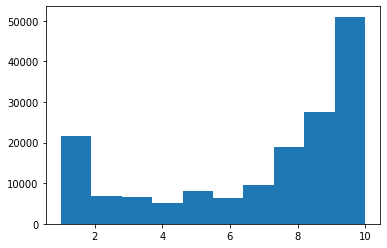

In [11]:
plt.hist(train_df['rating'])

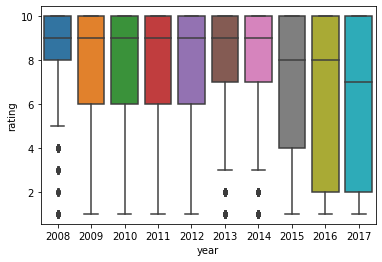

In [12]:
fig,ax=plt.subplots()
sns.boxplot(x=train_df['year'],y=train_df['rating'])
plt.show()

In [13]:
train_df.corr()

,uniqueID,rating,usefulCount,reviewLength,year
uniqueID,1.000000,0.015185,0.016475,0.006946,-0.007849
rating,0.015185,1.000000,0.234185,0.022879,-0.193388
usefulCount,0.016475,0.234185,1.000000,0.018760,-0.264861
reviewLength,0.006946,0.022879,0.018760,1.000000,0.227406
year,-0.007849,-0.193388,-0.264861,0.227406,1.000000


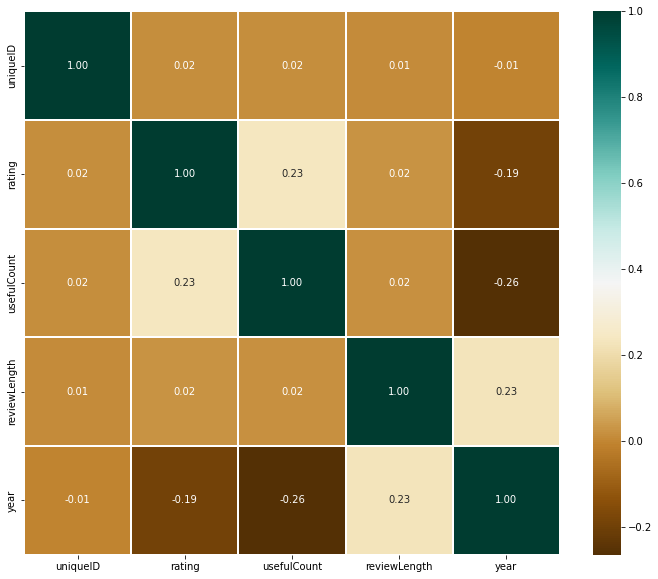

In [14]:
plt.figure(figsize=(12, 10))
ax=sns.heatmap(train_df.corr(),cmap = 'BrBG',fmt = '.2f',linewidths = 2,annot = True)

In [15]:
mean = train_df['rating'].mean()
print(mean)

6.994376832799122


In [16]:
train_df['new_rating'] = train_df[(train_df['rating'] > mean) | (train_df['rating'] < 5)]['rating']
test_df['new_rating'] = test_df[(test_df['rating'] > mean) | (test_df['rating'] < 5)]['rating']

train_df['new_rating'] = train_df['new_rating'].apply(lambda x: 1 if x > mean else 0)
test_df['new_rating'] = test_df['new_rating'].apply(lambda x: 1 if x > mean else 0)

train_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,reviewLength,year,new_rating
0,51452,Azithromycin,Chlamydia Infection,veri good respons it is so use for me,10,2010-08-18,1,9,2010,1
1,220696,Loestrin 24 Fe,Birth Control,im and i have been on loestrin for about a wee...,3,2010-11-03,2,137,2010,0
2,61073,Urea,Depression,accur inform,10,2011-07-02,13,2,2011,1
3,67383,Provera,Birth Control,im year old and have alway had a pretti regula...,1,2016-03-27,4,142,2016,0
4,81588,Yaz,Birth Control,i took yaz for a littl over year from around t...,3,2010-06-01,3,111,2010,0


<h1>Prediction 1</h1>

In [17]:
X_train = train_df['review']
X_test = test_df['review']
y_train = train_df['new_rating']
y_test = test_df['new_rating']

In [18]:
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,2))
X_train = vect.fit_transform(X_train.tolist())
X_test = vect.transform(X_test.tolist())

nb = MultinomialNB().fit(X_train, y_train)
train_pred = nb.predict(X_train)
test_pred = nb.predict(X_test)

print('Training Accuracy:', accuracy_score(y_train, train_pred))
print('Testing Accuracy:', accuracy_score(y_test, test_pred))

Training Accuracy: 0.9510592261480375
Testing Accuracy: 0.7765502362087565


<h1>Pre processing testing data</h1>

In [19]:
stemmer = PorterStemmer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokenized_words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in tokenized_words]
    processed_text = ' '.join(stemmed_words)
    return processed_text


test_df['review'] = test_df['review'].apply(preprocess_text)

In [20]:
special_chars_pattern = r'[!@#$%^&*(),.?":{}|<>]'

contains_special_chars = test_df['review'].str.contains(special_chars_pattern, regex=True)

print(contains_special_chars.sum())

0


<h1>Prediction 2</h1>

In [21]:
X_train = train_df['review']
X_test = test_df['review']
y_train = train_df['new_rating']
y_test = test_df['new_rating']

In [22]:
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,2))
X_train = vect.fit_transform(X_train.tolist())
X_test = vect.transform(X_test.tolist())

nb = MultinomialNB().fit(X_train, y_train)
train_pred = nb.predict(X_train)
test_pred = nb.predict(X_test)

print('Training Accuracy:', accuracy_score(y_train, train_pred))
print('Testing Accuracy:', accuracy_score(y_test, test_pred))

Training Accuracy: 0.9510592261480375
Testing Accuracy: 0.8797381244652754


<h1>Sentimental Analysis</h1>

In [23]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

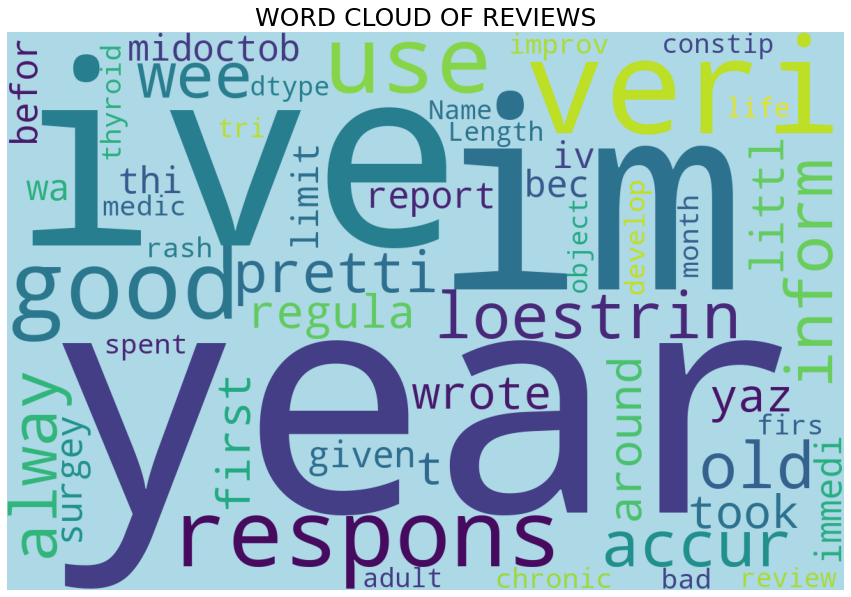

In [24]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(str(train_df['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('WORD CLOUD OF REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [25]:
train_df['new_rating'].value_counts()

1    106866
0     54431
Name: new_rating, dtype: int64

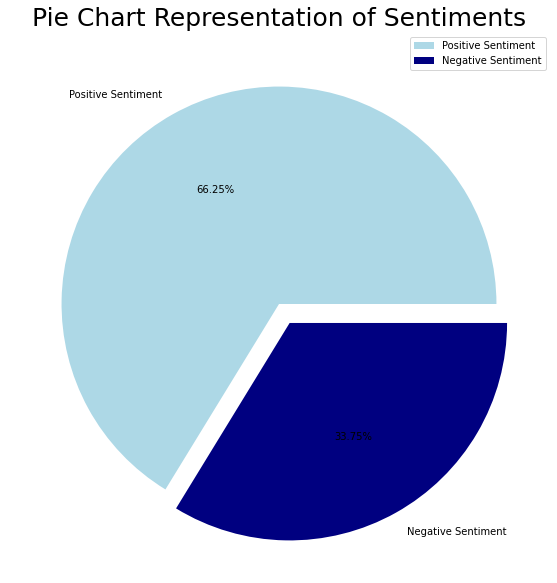

In [26]:
size = [106866,54431]
colors = ['lightblue', 'navy']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize = 25)
plt.legend()
plt.show()

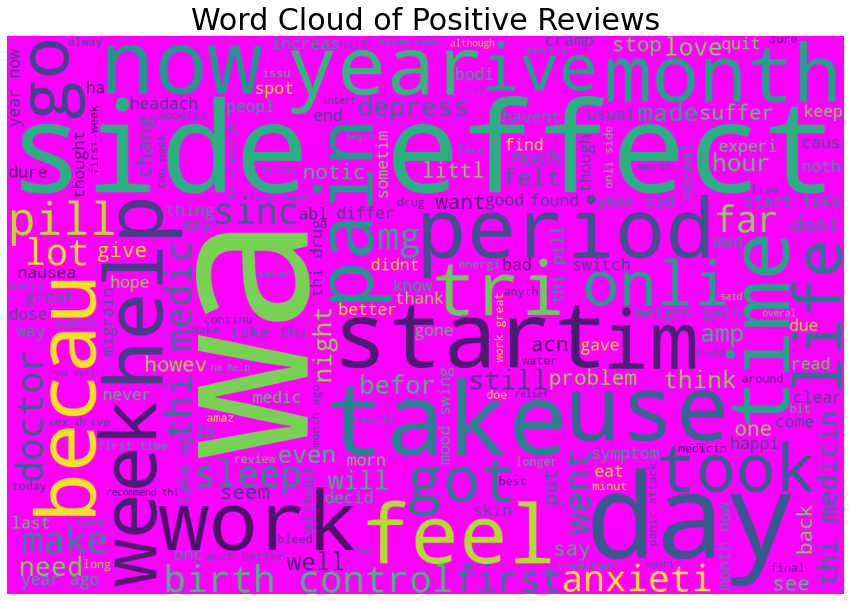

In [28]:
positive_sentiments = " ".join([text for text in train_df['review'][train_df['new_rating'] == 1]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'magenta', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

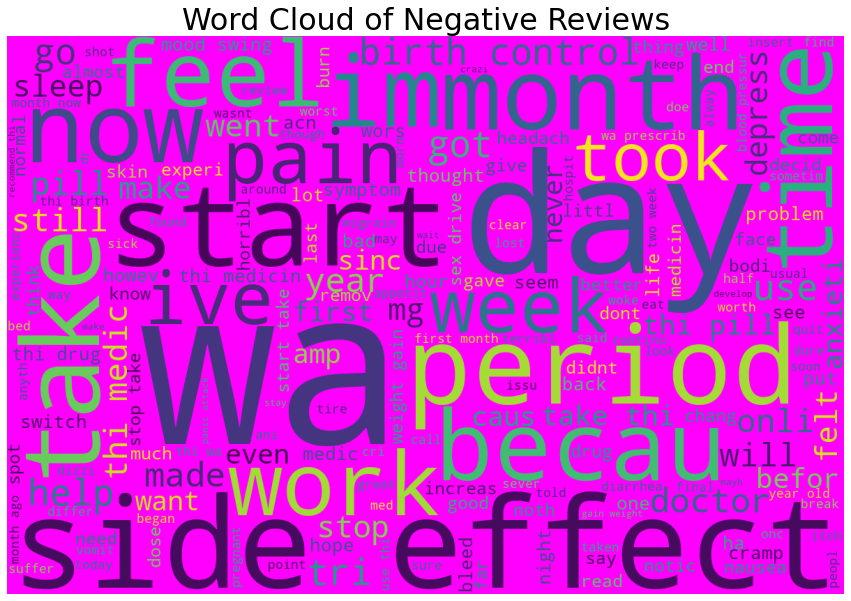

In [29]:
negative_sentiments = " ".join([text for text in train_df['review'][train_df['new_rating'] == 0]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'magenta', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer

s = SentimentIntensityAnalyzer()

In [35]:
sentiment_df = pd.DataFrame(train_df['review'].copy())

In [36]:
sentiment_df

,review
0,veri good respons it is so use for me
1,im and i have been on loestrin for about a wee...
2,accur inform
3,im year old and have alway had a pretti regula...
4,i took yaz for a littl over year from around t...
...,...
161292,i wrote my first report in midoctob of i have ...
161293,i wa given thi in iv befor surgey i immedi bec...
161294,limit improv after month develop bad rash and ...
161295,ive been on thyroid medic year i spent my firs...


In [38]:
sentiment_df['sentiment_score'] = sentiment_df['review'].apply(lambda x: s.polarity_scores(x)['compound'])

In [39]:
threshold_good = 0.3
threshold_bad = -0.3

sentiment_df['sentiment_category'] = sentiment_df['sentiment_score'].apply(lambda x: 'good' if x >= threshold_good else ('bad' if x <= threshold_bad else 'neutral'))

In [40]:
display(sentiment_df)

,review,sentiment_score,sentiment_category
0,veri good respons it is so use for me,0.4404,good
1,im and i have been on loestrin for about a wee...,-0.9366,bad
2,accur inform,0.0000,neutral
3,im year old and have alway had a pretti regula...,-0.9534,bad
4,i took yaz for a littl over year from around t...,0.8573,good
...,...,...,...
161292,i wrote my first report in midoctob of i have ...,0.9559,good
161293,i wa given thi in iv befor surgey i immedi bec...,-0.4215,bad
161294,limit improv after month develop bad rash and ...,-0.7351,bad
161295,ive been on thyroid medic year i spent my firs...,0.6069,good


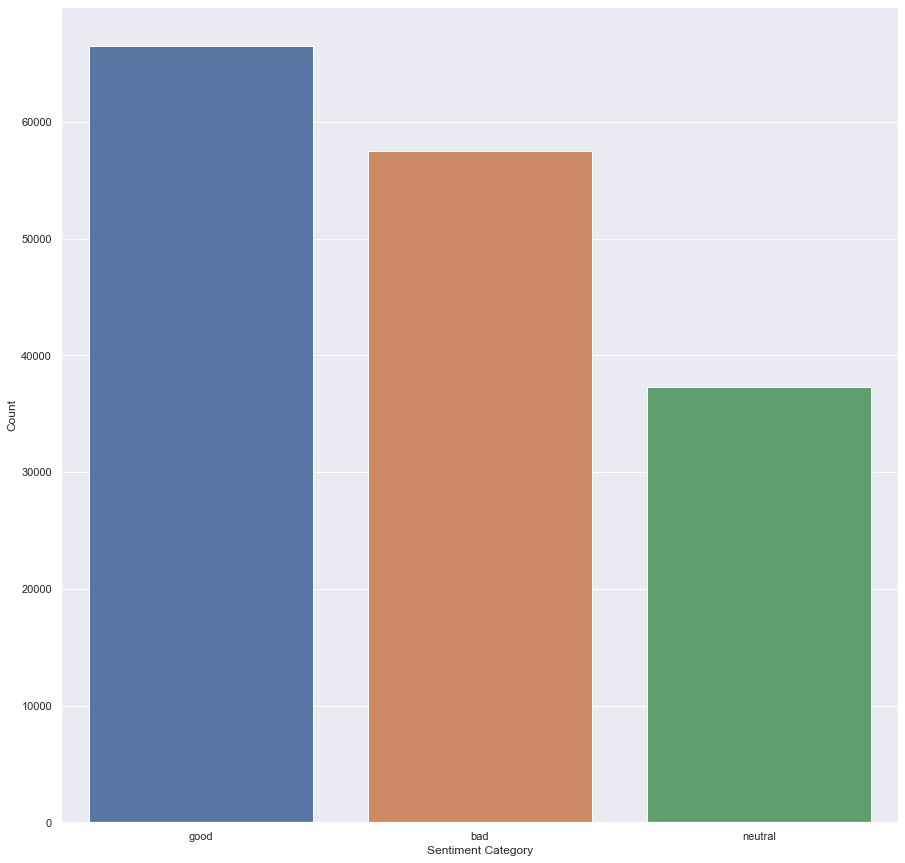

In [42]:
sns.set(style="darkgrid")
ax = sns.countplot(x="sentiment_category", data=sentiment_df , palette ='deep')
ax.set_xlabel("Sentiment Category")
ax.set_ylabel("Count")
plt.show()